✅ Image loaded successfully
✅ Detected 263 symbols
✅ Found 1 unique symbol types

🎯 Total unique detected patterns: 1


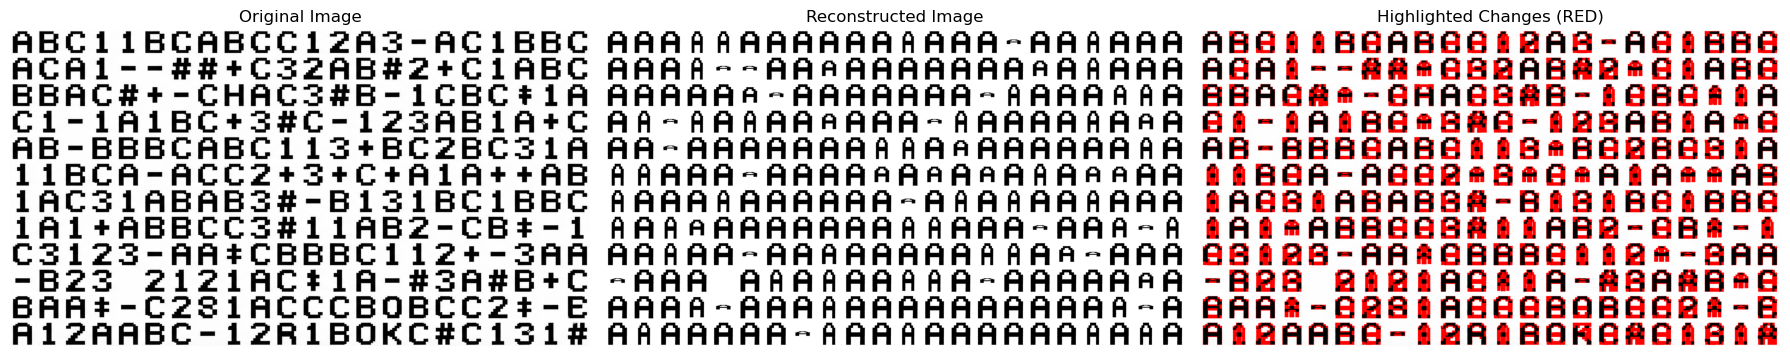

In [4]:
# ============================================================
# PATTERN SUBSTITUTION / SYMBOL GROUPING FROM IMAGE
# WITH CHANGE HIGHLIGHTING
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# MAIN FUNCTION
# ------------------------------------------------------------
def solve_pattern_substitution(image_path, threshold=0.15):

    if not os.path.exists(image_path):
        print("❌ Image path is wrong. File not found!")
        return None, None, 0

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    print("✅ Image loaded successfully")

    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    components = []

    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area < 5:
            continue

        roi = binary[y:y+h, x:x+w]
        resized = cv2.resize(roi, (20, 20), interpolation=cv2.INTER_AREA)

        components.append({
            "bbox": (x, y, w, h),
            "original": roi,
            "resized": resized,
            "group": -1
        })

    print(f"✅ Detected {len(components)} symbols")

    # ---------- GROUPING ----------
    prototypes = []

    for comp in components:
        matched = False
        for proto_img, proto_id in prototypes:
            diff = cv2.absdiff(comp["resized"], proto_img)
            mse = np.mean(diff) / 255.0

            if mse < threshold:
                comp["group"] = proto_id
                matched = True
                break

        if not matched:
            new_id = len(prototypes)
            prototypes.append((comp["resized"], new_id))
            comp["group"] = new_id

    print(f"✅ Found {len(prototypes)} unique symbol types")

    # ---------- RECONSTRUCTION ----------
    reconstructed = np.ones_like(img) * 255

    for comp in components:
        x, y, w, h = comp["bbox"]
        proto_roi = next(c["original"] for c in components if c["group"] == comp["group"])
        proto_resized = cv2.resize(proto_roi, (w, h), interpolation=cv2.INTER_AREA)
        reconstructed[y:y+h, x:x+w] = cv2.bitwise_not(proto_resized)

    return img, reconstructed, len(prototypes)


# ------------------------------------------------------------
# EXECUTION
# ------------------------------------------------------------

IMAGE_PATH = "img.png"   # 👈 change path here
THRESHOLD = 100

original, result, groups = solve_pattern_substitution(IMAGE_PATH, THRESHOLD)

if result is not None:

    print(f"\n🎯 Total unique detected patterns: {groups}")

    # ---------- CHANGE DET says ----------
    diff = cv2.absdiff(original, result)
    _, diff_mask = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Convert original to color
    highlight = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)

    # Highlight changes in RED
    highlight[diff_mask == 255] = [0, 0, 255]

    # ---------- DISPLAY ----------
    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(original, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Reconstructed Image")
    plt.imshow(result, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Highlighted Changes (RED)")
    plt.imshow(cv2.cvtColor(highlight, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

✅ Image loaded
Quality 90 -> PSNR: 43.88, SSIM: 0.9839
Quality 70 -> PSNR: 39.58, SSIM: 0.9681
Quality 50 -> PSNR: 37.60, SSIM: 0.9565
Quality 30 -> PSNR: 35.48, SSIM: 0.9390
Quality 10 -> PSNR: 30.70, SSIM: 0.8836


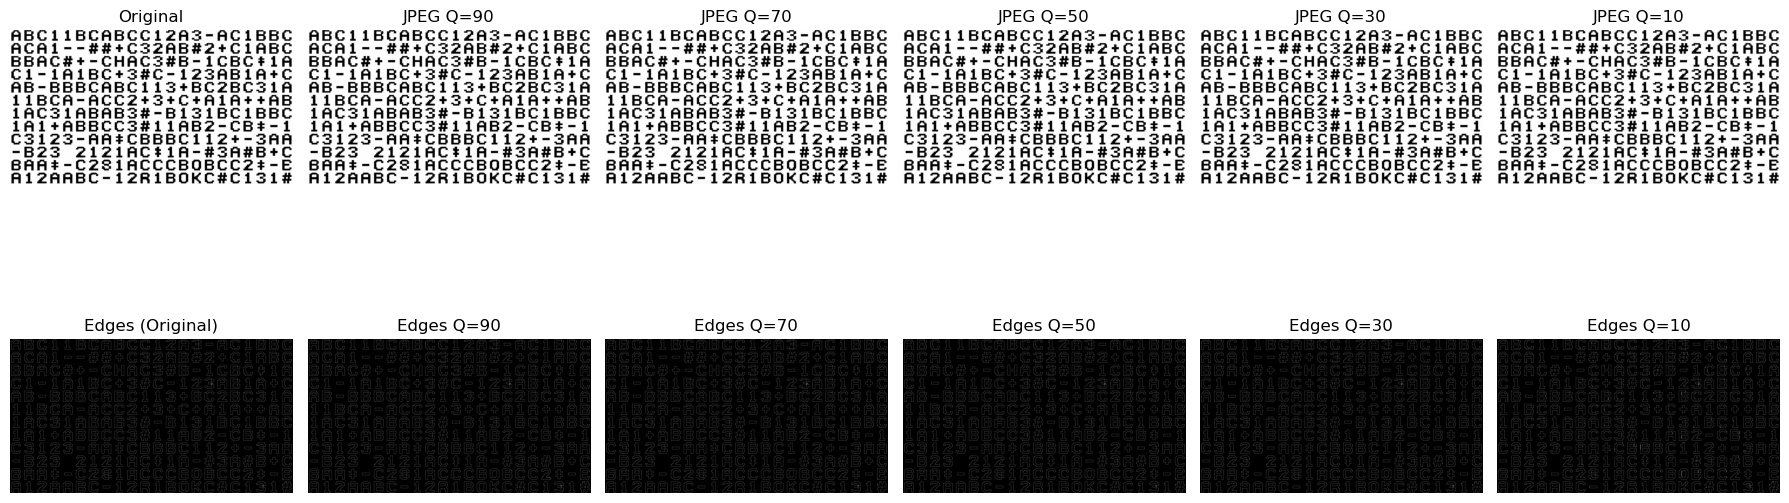


📊 QUALITY vs METRICS
Quality	PSNR		SSIM
-----------------------------------
90	43.88		0.9839
70	39.58		0.9681
50	37.60		0.9565
30	35.48		0.9390
10	30.70		0.8836


In [5]:
# ============================================================
# HUMAN-VISIBLE vs MACHINE-RELEVANT DIFFERENCES
#
# Tasks Covered:
# 1. Load grayscale image with text/patterns
# 2. Create JPEG compressed versions (different quality)
# 3. Compute PSNR and SSIM
# 4. Apply edge detection (machine-relevant task)
# 5. Compare perceptual metrics and algorithmic outputs
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import os

# ------------------------------------------------------------
# CHANGE IMAGE PATH HERE
# ------------------------------------------------------------
IMAGE_PATH = "img.png"   # <-- put your image path here

# JPEG quality levels to test
qualities = [90, 70, 50, 30, 10]

# ------------------------------------------------------------
# LOAD IMAGE
# ------------------------------------------------------------
original = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

if original is None:
    print("❌ Image not found")
    exit()

print("✅ Image loaded")

# Store results
compressed_images = []
metrics = []

# ------------------------------------------------------------
# JPEG COMPRESSION LOOP
# ------------------------------------------------------------
for q in qualities:

    filename = f"compressed_q{q}.jpg"
    cv2.imwrite(filename, original, [int(cv2.IMWRITE_JPEG_QUALITY), q])
    compressed = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # ---- PSNR & SSIM ----
    psnr_val = psnr(original, compressed)
    ssim_val = ssim(original, compressed)

    metrics.append((q, psnr_val, ssim_val))
    compressed_images.append(compressed)

    print(f"Quality {q} -> PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")

# ------------------------------------------------------------
# EDGE DETECTION (Machine-relevant processing)
# ------------------------------------------------------------
edges_original = cv2.Canny(original, 100, 200)
edges_versions = [cv2.Canny(img, 100, 200) for img in compressed_images]

# ------------------------------------------------------------
# DISPLAY RESULTS
# ------------------------------------------------------------
plt.figure(figsize=(18, 10))

plt.subplot(3, len(qualities)+1, 1)
plt.title("Original")
plt.imshow(original, cmap="gray")
plt.axis("off")

for i, q in enumerate(qualities):
    plt.subplot(3, len(qualities)+1, i+2)
    plt.title(f"JPEG Q={q}")
    plt.imshow(compressed_images[i], cmap="gray")
    plt.axis("off")

plt.subplot(3, len(qualities)+1, len(qualities)+2)
plt.title("Edges (Original)")
plt.imshow(edges_original, cmap="gray")
plt.axis("off")

for i, q in enumerate(qualities):
    plt.subplot(3, len(qualities)+1, len(qualities)+3+i)
    plt.title(f"Edges Q={q}")
    plt.imshow(edges_versions[i], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# PRINT METRIC TABLE
# ------------------------------------------------------------
print("\n📊 QUALITY vs METRICS")
print("Quality\tPSNR\t\tSSIM")
print("-"*35)
for q, p, s in metrics:
    print(f"{q}\t{p:.2f}\t\t{s:.4f}")

✅ Images loaded successfully
Lossless components: 265
Lossy components   : 265
🔥 Corrupted / distorted regions detected: 0


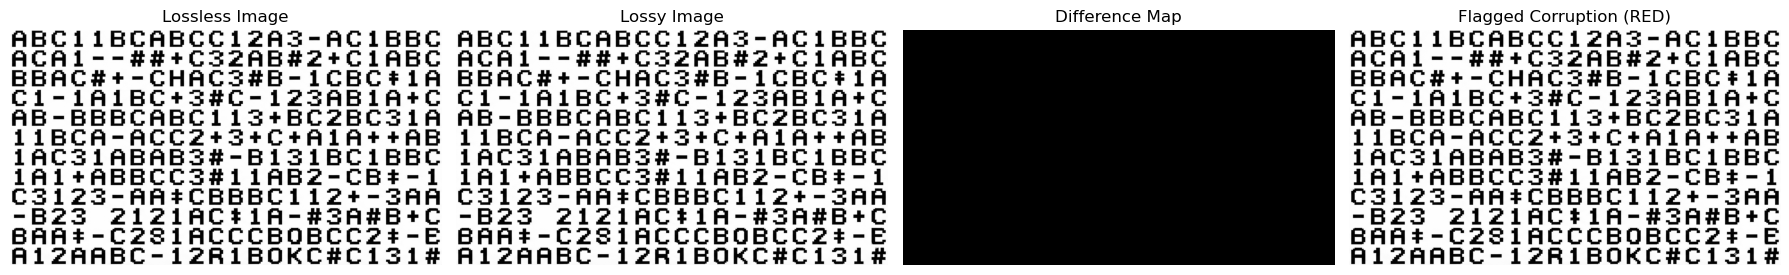

In [6]:
# ============================================================
# SILENT DATA CORRUPTION DETECTION
#
# Tasks covered:
# 1. Load two scanned versions of same document
# 2. Extract connected components / contours
# 3. Quantify structural differences (pixel-wise)
# 4. Flag regions where distortion/substitution occurred
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# CHANGE IMAGE PATHS HERE
# ------------------------------------------------------------
LOSSLESS_IMG = "img.png"   # safe compressed version
LOSSY_IMG    = "img.png"      # lossy compressed version

# ------------------------------------------------------------
# LOAD IMAGES
# ------------------------------------------------------------
img1 = cv2.imread(LOSSLESS_IMG, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(LOSSY_IMG, cv2.IMREAD_GRAYSCALE)

if img1 is None or img2 is None:
    print("❌ One or both images not found")
    exit()

print("✅ Images loaded successfully")

# Resize if size mismatch
if img1.shape != img2.shape:
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# ------------------------------------------------------------
# BINARIZATION (for structure extraction)
# ------------------------------------------------------------
_, bin1 = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY_INV)
_, bin2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY_INV)

# ------------------------------------------------------------
# CONNECTED COMPONENTS (STRUCTURE EXTRACTION)
# ------------------------------------------------------------
num1, _, stats1, _ = cv2.connectedComponentsWithStats(bin1, connectivity=8)
num2, _, stats2, _ = cv2.connectedComponentsWithStats(bin2, connectivity=8)

print("Lossless components:", num1-1)
print("Lossy components   :", num2-1)

# ------------------------------------------------------------
# PIXEL-WISE DIFFERENCE (STRUCTURAL CHANGE)
# ------------------------------------------------------------
diff = cv2.absdiff(img1, img2)
_, diff_mask = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

# Remove small noise
kernel = np.ones((3,3), np.uint8)
diff_mask = cv2.morphologyEx(diff_mask, cv2.MORPH_DILATE, kernel, iterations=2)

# ------------------------------------------------------------
# FIND AND FLAG DISTORTED REGIONS
# ------------------------------------------------------------
contours, _ = cv2.findContours(diff_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

highlight = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

corrupted_count = 0

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w*h > 30:   # ignore very tiny noise
        cv2.rectangle(highlight, (x,y), (x+w, y+h), (0,0,255), 2)
        corrupted_count += 1

print("🔥 Corrupted / distorted regions detected:", corrupted_count)

# ------------------------------------------------------------
# DISPLAY RESULTS
# ------------------------------------------------------------
plt.figure(figsize=(18,6))

plt.subplot(1,4,1)
plt.title("Lossless Image")
plt.imshow(img1, cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Lossy Image")
plt.imshow(img2, cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Difference Map")
plt.imshow(diff_mask, cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Flagged Corruption (RED)")
plt.imshow(cv2.cvtColor(highlight, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

✅ Image loaded

📊 IMAGE SIGNALS
-------------------------
Entropy            : 4.2
Edge density       : 0.0328
Connected components: 265

🎯 SAFE COMPRESSION DECISION
-----------------------------
➡ DO NOT COMPRESS (already simple / risky content)


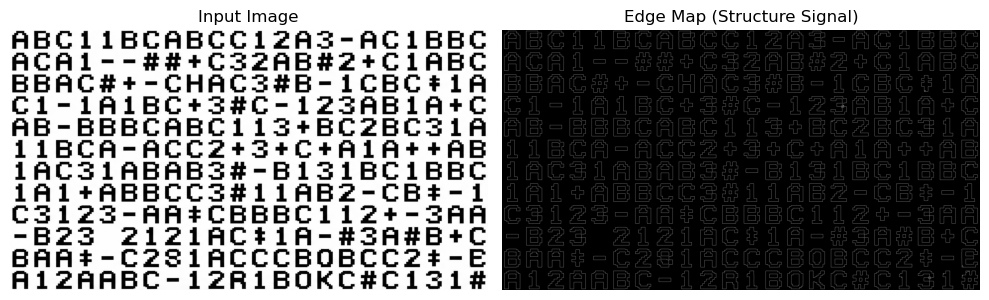

In [1]:
# ============================================================
# DESIGNING A "SAFE COMPRESSION" RULE
#
# Signals used:
# 1. Entropy  (information complexity)
# 2. Edge density (text/structure presence)
# 3. Connected components (symbol count)
#
# Output decision:
# - LOSSLESS compression
# - LOSSY compression
# - NOT compress
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy
import os

# ------------------------------------------------------------
# CHANGE IMAGE PATH HERE
# ------------------------------------------------------------
IMAGE_PATH = "img.png"   # try text image, form image, photo image

# ------------------------------------------------------------
# LOAD IMAGE
# ------------------------------------------------------------
img = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

if img is None:
    print("❌ Image not found")
    exit()

print("✅ Image loaded")

# ------------------------------------------------------------
# 1. ENTROPY (information content)
# ------------------------------------------------------------
entropy_val = shannon_entropy(img)

# ------------------------------------------------------------
# 2. EDGE DENSITY (structure amount)
# ------------------------------------------------------------
edges = cv2.Canny(img, 100, 200)
edge_density = np.sum(edges > 0) / edges.size

# ------------------------------------------------------------
# 3. CONNECTED COMPONENT COUNT
# ------------------------------------------------------------
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
component_count = num_labels - 1   # removing background

# ------------------------------------------------------------
# DECISION LOGIC (HEURISTIC RULES)
# ------------------------------------------------------------
if edge_density > 0.08 and component_count > 300:
    decision = "COMPRESS LOSSLESSLY (text / important document)"
    
elif entropy_val > 6.5 and edge_density < 0.05:
    decision = "COMPRESS LOSSILY (photo / natural image)"

else:
    decision = "DO NOT COMPRESS (already simple / risky content)"

# ------------------------------------------------------------
# PRINT RESULTS
# ------------------------------------------------------------
print("\n📊 IMAGE SIGNALS")
print("-------------------------")
print("Entropy            :", round(entropy_val, 2))
print("Edge density       :", round(edge_density, 4))
print("Connected components:", component_count)

print("\n🎯 SAFE COMPRESSION DECISION")
print("-----------------------------")
print("➡", decision)

# ------------------------------------------------------------
# DISPLAY IMAGE & EDGES
# ------------------------------------------------------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Edge Map (Structure Signal)")
plt.imshow(edges, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


In [1]:
import cv2, os

os.makedirs("templates", exist_ok=True)

img = cv2.imread("img.png", 0)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary, 8)

count = 0
for i in range(1, num_labels):
    x,y,w,h,a = stats[i]
    if a > 100:
        roi = binary[y:y+h, x:x+w]
        roi = cv2.resize(roi, (50,50))
        cv2.imwrite(f"templates/T{count}.png", roi)
        count += 1

print("✅ Templates auto-generated:", count)

✅ Templates auto-generated: 263


✅ Original and compressed images ready
✅ Templates loaded: ['T0', 'T1', 'T10', 'T100', 'T101', 'T102', 'T103', 'T104', 'T105', 'T106', 'T107', 'T108', 'T109', 'T11', 'T110', 'T111', 'T112', 'T113', 'T114', 'T115', 'T116', 'T117', 'T118', 'T119', 'T12', 'T120', 'T121', 'T122', 'T123', 'T124', 'T125', 'T126', 'T127', 'T128', 'T129', 'T13', 'T130', 'T131', 'T132', 'T133', 'T134', 'T135', 'T136', 'T137', 'T138', 'T139', 'T14', 'T140', 'T141', 'T142', 'T143', 'T144', 'T145', 'T146', 'T147', 'T148', 'T149', 'T15', 'T150', 'T151', 'T152', 'T153', 'T154', 'T155', 'T156', 'T157', 'T158', 'T159', 'T16', 'T160', 'T161', 'T162', 'T163', 'T164', 'T165', 'T166', 'T167', 'T168', 'T169', 'T17', 'T170', 'T171', 'T172', 'T173', 'T174', 'T175', 'T176', 'T177', 'T178', 'T179', 'T18', 'T180', 'T181', 'T182', 'T183', 'T184', 'T185', 'T186', 'T187', 'T188', 'T189', 'T19', 'T190', 'T191', 'T192', 'T193', 'T194', 'T195', 'T196', 'T197', 'T198', 'T199', 'T2', 'T20', 'T200', 'T201', 'T202', 'T203', 'T204', 'T205

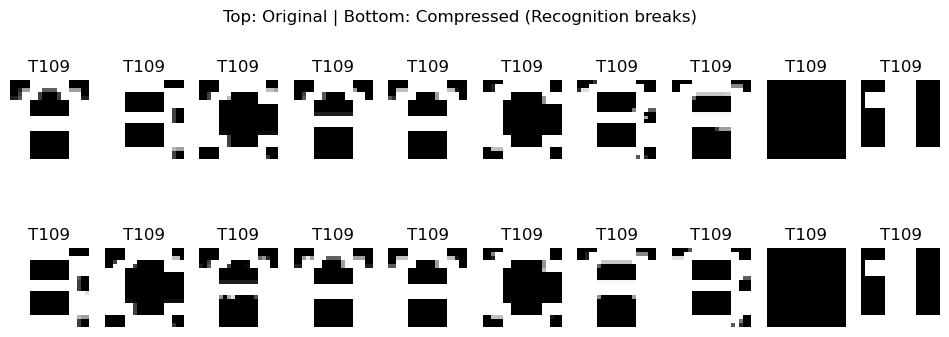

In [2]:
# ============================================================
# WHEN COMPRESSION BREAKS A DOWNSTREAM TASK
#
# - Simple rule-based character recognizer (template matching)
# - Test on original and heavily compressed images
# - Measure recognition accuracy
# - Identify which characters fail first
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# CHANGE PATHS HERE
# ------------------------------------------------------------
ORIGINAL_IMG = "img.png"      # clean document image with characters
TEMPLATE_DIR = "templates"    # folder containing character templates
# Example templates: A.png, B.png, 0.png, 1.png ...

# ------------------------------------------------------------
# CREATE HEAVILY COMPRESSED VERSION
# ------------------------------------------------------------
orig = cv2.imread(ORIGINAL_IMG, cv2.IMREAD_GRAYSCALE)

cv2.imwrite("compressed.jpg", orig, [int(cv2.IMWRITE_JPEG_QUALITY), 10])
compressed = cv2.imread("compressed.jpg", cv2.IMREAD_GRAYSCALE)

print("✅ Original and compressed images ready")

# ------------------------------------------------------------
# LOAD CHARACTER TEMPLATES (RULE BASE)
# ------------------------------------------------------------
templates = {}

for file in os.listdir(TEMPLATE_DIR):
    label = file.split(".")[0]          # A.png → "A"
    img = cv2.imread(os.path.join(TEMPLATE_DIR, file), 0)
    img = cv2.resize(img, (20,20))
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    templates[label] = img

print("✅ Templates loaded:", list(templates.keys()))

# ------------------------------------------------------------
# CHARACTER SEGMENTATION
# ------------------------------------------------------------
def segment_characters(image):
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)

    chars = []
    for i in range(1, num_labels):
        x,y,w,h,area = stats[i]
        if area > 50:
            roi = binary[y:y+h, x:x+w]
            roi = cv2.resize(roi, (20,20))
            chars.append((x, roi))
    chars = sorted(chars, key=lambda x: x[0])
    return [c[1] for c in chars]

# ------------------------------------------------------------
# RULE-BASED RECOGNIZER (TEMPLATE MATCHING)
# ------------------------------------------------------------
def recognize(char_img):
    best_score = -1
    best_label = "?"

    for label, temp in templates.items():
        score = cv2.matchTemplate(char_img, temp, cv2.TM_CCOEFF_NORMED)[0][0]
        if score > best_score:
            best_score = score
            best_label = label

    return best_label, best_score

# ------------------------------------------------------------
# TEST FUNCTION
# ------------------------------------------------------------
def test_system(image, name="IMAGE"):
    chars = segment_characters(image)
    predictions = []

    for ch in chars:
        label, score = recognize(ch)
        predictions.append((label, score))

    print(f"\n📄 Results on {name}:")
    print(predictions)
    return predictions, chars

# ------------------------------------------------------------
# RUN TESTS
# ------------------------------------------------------------
orig_pred, orig_chars = test_system(orig, "ORIGINAL")
comp_pred, comp_chars = test_system(compressed, "COMPRESSED")

# ------------------------------------------------------------
# ACCURACY COMPARISON
# (Assuming original predictions are ground truth)
# ------------------------------------------------------------
correct = 0
failed = {}

for i in range(min(len(orig_pred), len(comp_pred))):
    if orig_pred[i][0] == comp_pred[i][0]:
        correct += 1
    else:
        failed[orig_pred[i][0]] = failed.get(orig_pred[i][0], 0) + 1

accuracy = correct / len(orig_pred) * 100

print("\n🎯 RECOGNITION ACCURACY ON COMPRESSED IMAGE:", round(accuracy,2), "%")
print("🔥 Characters that failed first:", failed)

# ------------------------------------------------------------
# VISUALIZE FAILURES
# ------------------------------------------------------------
plt.figure(figsize=(12,4))

for i in range(min(10, len(orig_chars))):
    plt.subplot(2,10,i+1)
    plt.imshow(orig_chars[i], cmap="gray")
    plt.title(orig_pred[i][0])
    plt.axis("off")

    plt.subplot(2,10,i+11)
    plt.imshow(comp_chars[i], cmap="gray")
    plt.title(comp_pred[i][0])
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: Compressed (Recognition breaks)")
plt.show()